In [94]:
import os
import string
from tqdm import tqdm
from itertools import combinations
from zipfile import ZipFile
import re
import pandas as pd
from sklearn.feature_extraction.text  import TfidfTransformer, CountVectorizer
import itertools
from matplotlib import pyplot as plt

# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

s=set(stopwords.words('english'))
start = 'C:/Users/gony/Desktop/'

# Functions:

In [105]:
def tf_idf_weights(docs):
    #instantiate CountVectorizer()
    cv=CountVectorizer()
    # this steps generates word counts for the words in your docs
    word_count_vector=cv.fit_transform(docs)
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])
    plt.hist(df_idf.idf_weights)
    plt.show()
    relevent_words = df_idf[df_idf.idf_weights > 9].index.values
    return relevent_words


def remove_stopwords_numbers(text):
    return list(filter(lambda w: not w.lower() in s and not w.isdigit(),text))


def split_sentences(day):
    day['sentences'] = [tokenize.sent_tokenize(t)[:-1] for t in day.text]
    day['sentences'] = [[x[x.find(':')+3:] if x.find(':') != -1 else x for x in sen] for sen in day.sentences]
    # removing punctiuation marks from each sentence
    day['sentences'] = [[s.translate(str.maketrans('', '', string.punctuation)) for s in t] for t in day.sentences]
    day['words_sentences'] =[[list(filter(lambda w: not w.lower() in s and not w.isdigit(),sen.split())) for sen in text] for text in day.sentences]
    return day


lemmatizer = WordNetLemmatizer()
def create_nodes_edges(data, relevent_words):
    # creating emtpy df
    output_graph = pd.DataFrame(columns=['source', 'target'])
    
    # iterating over each row 
    for i, row in tqdm(data.iterrows()):
        temp = row['words_sentences']
        
        # iterating over each sentence, since we are creating an each between two words
        # if the appeared together in the same sentence
        for sen in temp:
            sen = [w for w in sen if w in relevent_words and not w.isdigit()]
            pos_tags = pos_tag(sen)
            # creates list of permutation of 2 for all the words in the sentence
            lemmatized_words = []
            for word, pos in pos_tags:
                if pos.startswith('V'):  # Verbs
                    lemma = lemmatizer.lemmatize(word, pos='v')
                elif pos.startswith('N'):  # Nouns
                    lemma = lemmatizer.lemmatize(word, pos='n')
                else:
                    lemma = word  # Keep the word as is
                lemmatized_words.append(lemma)

            # Join the lemmatized words back into a sentence
            # creates list of permutation of 2 for all the words in the sentence
            temp_df = pd.DataFrame(data =list(combinations([x.lower() for x in lemmatized_words], 2)), columns=['source', 'target'])
            output_graph = output_graph.append(temp_df, ignore_index = True)
    
#     # groupby source and target and count all the apperance
#     output_graph['count']=output_graph.groupby('source')['target'].transform('count')#all rows ; 
    count_series = output_graph.groupby(['source', 'target']).size()

#     # remove duplicates
#     output_graph.drop_duplicates(inplace=True)
    new_df = count_series.to_frame(name = 'weight').reset_index()

    return new_df

# 9/11


## Calculate TF-IDF weights
The lower the IDF value of a word, the less unique it is to any particular document.

c:\users\gony\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


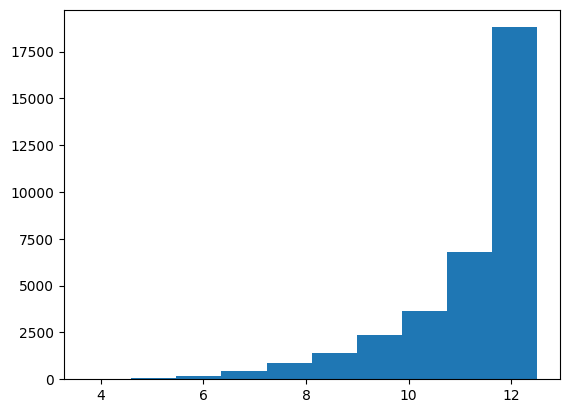

In [107]:
path = start+'data/9_11_2001.zip'
sentences = []
with ZipFile(path, "r") as zip_ref:
    for f in zip_ref.namelist():
        idx = [i for i, ltr in enumerate(f) if ltr == '.']
        num_day = int(f[:idx[0]])
        num_month = int(f[idx[0]+1:idx[1]])
        if (num_month==9 and num_day>=6 and num_day<=26):
            day = pd.read_csv(zip_ref.open(f))
            day['sentences'] = [tokenize.sent_tokenize(t)[:-1] for t in day.text]
            day['sentences'] = [[x[x.find(':')+3:] if x.find(':') != -1 else x for x in sen] for sen in day.sentences]
            # removing punctiuation marks from each sentence
            day['sentences'] = [[s.translate(str.maketrans('', '', string.punctuation)) for s in t] for t in day.sentences]
            sentences.extend(day['sentences'])

sentences = list(itertools.chain(*sentences))
docs = [' '.join(remove_stopwords_numbers(x.split())) for x in sentences]
relevent_words = tf_idf_weights(docs)

## Create nodes:

In [49]:
path = start+'data/9_11_2001.zip'
with ZipFile(path, "r") as zip_ref:
    for f in zip_ref.namelist():
        idx = [i for i, ltr in enumerate(f) if ltr == '.']
        num_day = int(f[:idx[0]])
        num_month = int(f[idx[0]+1:idx[1]])
        if (num_month==9 and num_day>=6 and num_day<=26):
            print(f)
            day = pd.read_csv(zip_ref.open(f))
            day = split_sentences(day)
            create_nodes_edges(day, relevent_words).to_csv(start+'data/nodes - Copy/9_11_2001/nodes' + f)

10.09.2001.csv


102it [02:04,  1.22s/it]


11.09.2001.csv


110it [02:44,  1.49s/it]


12.09.2001.csv


115it [02:18,  1.21s/it]


13.09.2001.csv


145it [02:49,  1.17s/it]


14.09.2001.csv


120it [02:04,  1.03s/it]


15.09.2001.csv


71it [01:42,  1.44s/it]


16.09.2001.csv


31it [01:45,  3.39s/it]


17.09.2001.csv


93it [01:51,  1.20s/it]


18.09.2001.csv


100it [01:49,  1.09s/it]


19.09.2001.csv


88it [01:49,  1.24s/it]


20.09.2001.csv


117it [01:38,  1.19it/s]


21.09.2001.csv


100it [01:32,  1.08it/s]


22.09.2001.csv


83it [01:34,  1.14s/it]


23.09.2001.csv


46it [00:59,  1.29s/it]


24.09.2001.csv


89it [01:33,  1.05s/it]


25.09.2001.csv


91it [01:34,  1.04s/it]


26.09.2001.csv


92it [02:27,  1.60s/it]


6.09.2001.csv


80it [02:15,  1.69s/it]


7.09.2001.csv


102it [02:48,  1.65s/it]


8.09.2001.csv


54it [02:03,  2.29s/it]


9.09.2001.csv


54it [01:27,  1.62s/it]


# Iraq invasion, March 2003


## Calculate TF-IDF weights
The lower the IDF value of a word, the less unique it is to any particular document.

c:\users\gony\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


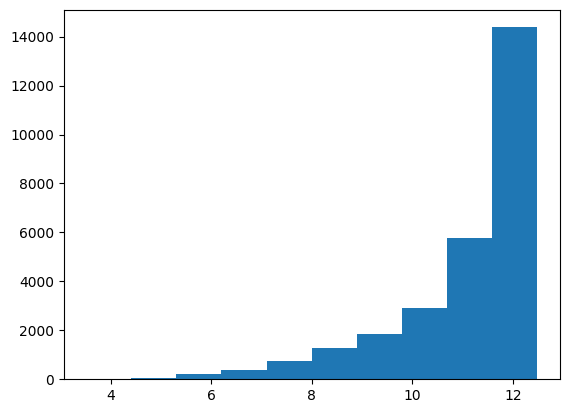

In [127]:
path = start+'data/iraq_3_20_2003.zip'
sentences = []
with ZipFile(path, "r") as zip_ref:
    for f in zip_ref.namelist():
        idx = [i for i, ltr in enumerate(f) if ltr == '.']
        num_day = int(f[:idx[0]])
        num_month = int(f[idx[0]+1:idx[1]])
        if ((num_month==4 and num_day<=3) or (num_month==3 and num_day>=16)):
            day = pd.read_csv(zip_ref.open(f))
            day.dropna(subset=['text'], inplace=True)
            day['sentences'] = [tokenize.sent_tokenize(t)[:-1] for t in day.text]
            day['sentences'] = [[x[x.find(':')+3:] if x.find(':') != -1 else x for x in sen] for sen in day.sentences]
            # removing punctiuation marks from each sentence
            day['sentences'] = [[s.translate(str.maketrans('', '', string.punctuation)) for s in t] for t in day.sentences]
            sentences.extend(day['sentences'])


sentences = list(itertools.chain(*sentences))
docs = [' '.join(remove_stopwords_numbers(x.split())) for x in sentences]
relevent_words = tf_idf_weights(docs)

## Create nodes:

In [128]:
path = start+'data/iraq_3_20_2003.zip'
with ZipFile(path, "r") as zip_ref:
    for f in zip_ref.namelist():
        idx = [i for i, ltr in enumerate(f) if ltr == '.']
        num_day = int(f[:idx[0]])
        num_month = int(f[idx[0]+1:idx[1]])
        if ((num_month==4 and num_day<=3) or (num_month==3 and num_day>=16)):
            print(f)
            day = pd.read_csv(zip_ref.open(f))
            day.dropna(subset=['text'], inplace=True)
            day = split_sentences(day)
            create_nodes_edges(day, relevent_words).to_csv(start+'data/nodes - Copy/iraq_3_20_2003/nodes' + f)


1.04.2003.csv


78it [01:48,  1.39s/it]


16.03.2003.csv


48it [01:18,  1.63s/it]


17.03.2003.csv


62it [01:14,  1.21s/it]


18.03.2003.csv


71it [01:16,  1.08s/it]


19.03.2003.csv


65it [01:27,  1.35s/it]


2.04.2003.csv


86it [02:03,  1.44s/it]


20.03.2003.csv


88it [02:24,  1.64s/it]


21.03.2003.csv


64it [02:16,  2.14s/it]


22.03.2003.csv


41it [02:34,  3.78s/it]


23.03.2003.csv


25it [02:14,  5.40s/it]


24.03.2003.csv


55it [02:57,  3.22s/it]


25.03.2003.csv


69it [02:24,  2.09s/it]


26.03.2003.csv


99it [02:21,  1.42s/it]


27.03.2003.csv


74it [01:54,  1.54s/it]


28.03.2003.csv


72it [01:54,  1.59s/it]


29.03.2003.csv


43it [02:18,  3.23s/it]


3.04.2003.csv


53it [01:47,  2.02s/it]


30.03.2003.csv


47it [01:49,  2.33s/it]


31.03.2003.csv


66it [01:24,  1.27s/it]


# Hurrican Katrina


## Calculate TF-IDF weights
The lower the IDF value of a word, the less unique it is to any particular document.

c:\users\gony\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


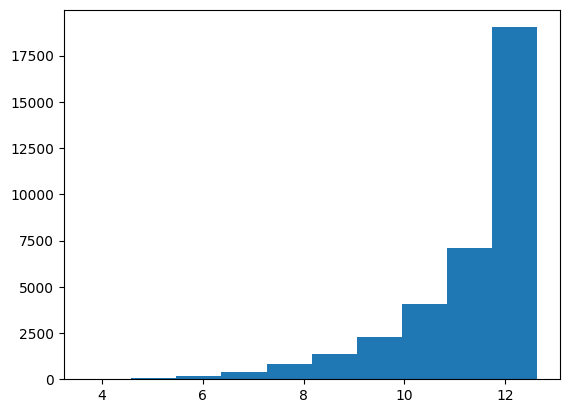

In [115]:
path = start + 'data/katrina_08_2005.zip'
sentences = []
with ZipFile(path, "r") as zip_ref:
    for f in zip_ref.namelist():
        idx = [i for i, ltr in enumerate(f) if ltr == '.']
        num_day = int(f[:idx[0]])
        num_month = int(f[idx[0]+1:idx[1]])
        if ((num_month==9 and num_day<=6) or (num_month==8 and num_day>=18)):
            day = pd.read_csv(zip_ref.open(f))
            day['sentences'] = [tokenize.sent_tokenize(t)[:-1] for t in day.text]
            day['sentences'] = [[x[x.find(':')+3:] if x.find(':') != -1 else x for x in sen] for sen in day.sentences]
            # removing punctiuation marks from each sentence
            day['sentences'] = [[s.translate(str.maketrans('', '', string.punctuation)) for s in t] for t in day.sentences]
            sentences.extend(day['sentences'])

sentences = list(itertools.chain(*sentences))
docs = [' '.join(remove_stopwords_numbers(x.split())) for x in sentences]
relevent_words = tf_idf_weights(docs)

## Create nodes:

In [116]:
path = start + 'data/katrina_08_2005.zip'
with ZipFile(path, "r") as zip_ref:
    for f in zip_ref.namelist():
        idx = [i for i, ltr in enumerate(f) if ltr == '.']
        num_day = int(f[:idx[0]])
        num_month = int(f[idx[0]+1:idx[1]])
        if ((num_month==9 and num_day<=6) or (num_month==8 and num_day>=18)):
            print(f)
            day = pd.read_csv(zip_ref.open(f))
            day = split_sentences(day)
            create_nodes_edges(day, relevent_words).to_csv(start+'data/nodes - Copy/katrina_08_2005/nodes' + f)


1.09.2005.csv


28it [02:31,  5.40s/it]


18.08.2005.csv


23it [03:00,  7.83s/it]


19.08.2005.csv


28it [02:11,  4.68s/it]


2.09.2005.csv


25it [03:17,  7.90s/it]


20.08.2005.csv


15it [02:00,  8.04s/it]


21.08.2005.csv


12it [02:59, 14.98s/it]


22.08.2005.csv


29it [04:52, 10.08s/it]


23.08.2005.csv


28it [03:11,  6.85s/it]


24.08.2005.csv


28it [03:29,  7.47s/it]


25.08.2005.csv


31it [03:28,  6.71s/it]


26.08.2005.csv


29it [03:12,  6.65s/it]


27.08.2005.csv


21it [02:46,  7.94s/it]


28.08.2005.csv


15it [02:07,  8.51s/it]


29.08.2005.csv


25it [03:23,  8.15s/it]


3.09.2005.csv


17it [01:39,  5.87s/it]


30.08.2005.csv


31it [02:56,  5.68s/it]


31.08.2005.csv


25it [02:14,  5.39s/it]


4.09.2005.csv


12it [01:28,  7.34s/it]


5.09.2005.csv


27it [02:11,  4.89s/it]


6.09.2005.csv


29it [02:20,  4.83s/it]


# Bin Ladin - May 2011


## Calculate TF-IDF weights
The lower the IDF value of a word, the less unique it is to any particular document.

c:\users\gony\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


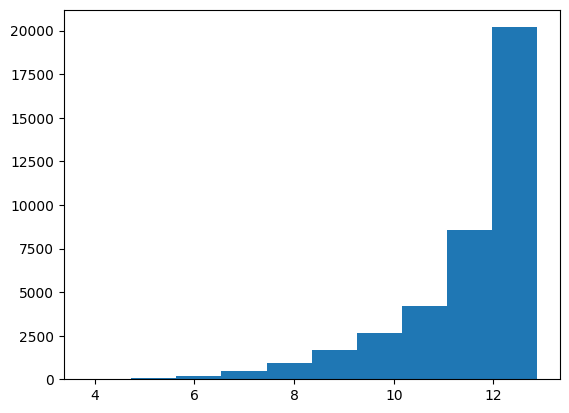

In [113]:
path = start+'data/binladin_02_05_2011.zip'
sentences = []
with ZipFile(path, "r") as zip_ref:
    for f in zip_ref.namelist():
        idx = [i for i, ltr in enumerate(f) if ltr == '.']
        num_day = int(f[:idx[0]])
        num_month = int(f[idx[0]+1:idx[1]])
        if ((num_month==5 and num_day<=17) or (num_month==4 and num_day>=27)):
            day = pd.read_csv(zip_ref.open(f))
            day['sentences'] = [tokenize.sent_tokenize(t)[:-1] for t in day.text]
            day['sentences'] = [[x[x.find(':')+3:] if x.find(':') != -1 else x for x in sen] for sen in day.sentences]
            # removing punctiuation marks from each sentence
            day['sentences'] = [[s.translate(str.maketrans('', '', string.punctuation)) for s in t] for t in day.sentences]
            sentences.extend(day['sentences'])

sentences = list(itertools.chain(*sentences))
docs = [' '.join(remove_stopwords_numbers(x.split())) for x in sentences]
relevent_words = tf_idf_weights(docs)

## Create nodes:

In [114]:
path = start+'data/binladin_02_05_2011.zip'
with ZipFile(path, "r") as zip_ref:
    for f in zip_ref.namelist():
        idx = [i for i, ltr in enumerate(f) if ltr == '.']
        num_day = int(f[:idx[0]])
        num_month = int(f[idx[0]+1:idx[1]])
        if ((num_month==5 and num_day<=17) or (num_month==4 and num_day>=27)):
            print(f)
            day = pd.read_csv(zip_ref.open(f))
            day = split_sentences(day)
            create_nodes_edges(day, relevent_words).to_csv(start+'data/nodes - Copy/binladin_02_05_2011/nodes' + f)


1.05.2011.csv


17it [02:21,  8.34s/it]


10.05.2011.csv


26it [04:00,  9.24s/it]


11.05.2011.csv


28it [05:27, 11.69s/it]


12.05.2011.csv


28it [04:13,  9.07s/it]


13.05.2011.csv


26it [03:59,  9.19s/it]


14.05.2011.csv


20it [02:23,  7.18s/it]


15.05.2011.csv


14it [01:57,  8.42s/it]


16.05.2011.csv


26it [03:40,  8.47s/it]


17.05.2011.csv


26it [04:00,  9.26s/it]


2.05.2011.csv


37it [05:28,  8.87s/it]


27.04.2011.csv


28it [04:03,  8.71s/it]


28.04.2011.csv


26it [04:42, 10.88s/it]


29.04.2011.csv


27it [04:48, 10.68s/it]


3.05.2011.csv


27it [04:29,  9.97s/it]


30.04.2011.csv


19it [02:25,  7.67s/it]


4.05.2011.csv


28it [04:40, 10.03s/it]


5.05.2011.csv


27it [06:21, 14.12s/it]


6.05.2011.csv


26it [04:13,  9.75s/it]


7.05.2011.csv


20it [02:42,  8.11s/it]


8.05.2011.csv


14it [02:26, 10.49s/it]


9.05.2011.csv


26it [04:32, 10.48s/it]


# Boston Terror Attach - April 2013


## Calculate TF-IDF weights
The lower the IDF value of a word, the less unique it is to any particular document.

c:\users\gony\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


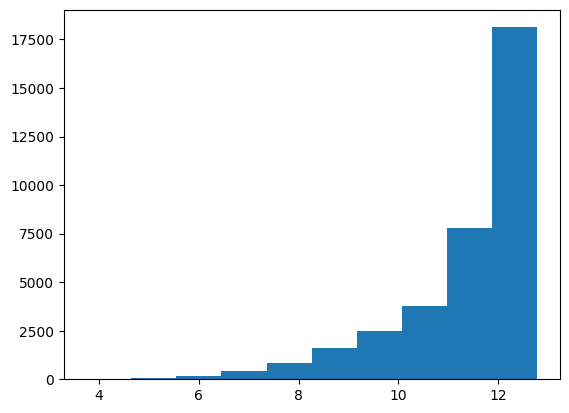

In [111]:
path = start+'data/boston_15_04_2013.zip'
sentences = []
with ZipFile(path, "r") as zip_ref:
    for f in zip_ref.namelist():
        idx = [i for i, ltr in enumerate(f) if ltr == '.']
        num_day = int(f[:idx[0]])
        num_month = int(f[idx[0]+1:idx[1]])
        if (num_month==4 and (num_day>= 11 or num_day<=30)):
            day = pd.read_csv(zip_ref.open(f))
            day['sentences'] = [tokenize.sent_tokenize(t)[:-1] for t in day.text]
            day['sentences'] = [[x[x.find(':')+3:] if x.find(':') != -1 else x for x in sen] for sen in day.sentences]
            # removing punctiuation marks from each sentence
            day['sentences'] = [[s.translate(str.maketrans('', '', string.punctuation)) for s in t] for t in day.sentences]
            sentences.extend(day['sentences'])

sentences = list(itertools.chain(*sentences))
docs = [' '.join(remove_stopwords_numbers(x.split())) for x in sentences]
relevent_words = tf_idf_weights(docs)

## Create nodes:

In [112]:
path = start+'data/boston_15_04_2013.zip'
with ZipFile(path, "r") as zip_ref:
    for f in zip_ref.namelist():
        idx = [i for i, ltr in enumerate(f) if ltr == '.']
        num_day = int(f[:idx[0]])
        num_month = int(f[idx[0]+1:idx[1]])
        if (num_month==4 and (num_day>= 11 or num_day<=30)):
            print(f)
            day = pd.read_csv(zip_ref.open(f))
            day = split_sentences(day)
            create_nodes_edges(day, relevent_words).to_csv(start+'data/nodes - Copy/boston_15_04_2013/nodes' + f)


11.04.2013.csv


39it [04:18,  6.63s/it]


12.04.2013.csv


40it [03:17,  4.93s/it]


13.04.2013.csv


19it [02:08,  6.75s/it]


14.04.2013.csv


14it [01:38,  7.03s/it]


15.04.2013.csv


40it [03:42,  5.56s/it]


16.04.2013.csv


47it [04:15,  5.44s/it]


17.04.2013.csv


42it [03:25,  4.89s/it]


18.04.2013.csv


46it [05:06,  6.66s/it]


19.04.2013.csv


43it [04:26,  6.20s/it]


20.04.2013.csv


22it [02:38,  7.20s/it]


21.04.2013.csv


17it [01:47,  6.33s/it]


22.04.2013.csv


41it [03:03,  4.47s/it]


23.04.2013.csv


41it [03:27,  5.07s/it]


24.04.2013.csv


39it [02:47,  4.29s/it]


25.04.2013.csv


39it [02:49,  4.35s/it]


26.04.2013.csv


38it [02:44,  4.33s/it]


27.04.2013.csv


20it [01:45,  5.29s/it]


28.04.2013.csv


14it [01:31,  6.54s/it]


29.04.2013.csv


39it [02:26,  3.76s/it]


30.04.2013.csv


39it [02:11,  3.37s/it]
